In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tskit
import msprime
import demes

import sys
sys.path.append('/home/hblee/tsblup')
import tslmm
import tslmm.operations as operations
import tslmm.matrices as matrices
from tslmm.tslmm import TSLMM
from tslmm.tslmm import _explicit_covariance_matrix

In [2]:
def simulate(sigma, tau, tree_sequence, mutation_rate, rng=None, subset=None, center_covariance=False):
    """
    float sigma: non-genetic variance, i.e., residual
    float tau: genetic variance
    tskit.TreeSequence tree_sequence: tree sequence
    float mutation_rate: mutation rate (e.g. 1e-8)
    np.random.Generator rng: numpy random number generator
    np.ndarray subset: index of individuals to use # currently not active option
    bool center_covariance: center covariance if True
    """
    if rng is None: rng = np.random.default_rng()
    if subset is None: subset = np.arange(tree_sequence.num_individuals)
    G = _explicit_covariance_matrix(
        0, tau, tree_sequence, mutation_rate, 
        center_around=subset if center_covariance else None,
    )
    U = np.linalg.cholesky(G)
    X = rng.normal(size=(tree_sequence.num_individuals, 5)) # covariates
    g = U @ rng.normal(size=tree_sequence.num_individuals) # genetic value 
    e = rng.normal(size=tree_sequence.num_individuals) * np.sqrt(sigma) # residual
    b = rng.normal(size=5) # fixed effect size
    y = X @ b + g + e # trait value
    return y, X, b, g

In [3]:
# example tree sequence
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population(name="B", initial_size=10_000)
demography.add_population(name="ancestral", initial_size=1_000)
demography.add_population_split(time=1000, 
                                derived=["A", "B"],
                                ancestral="ancestral")
seq_length = 1e6
ts = msprime.sim_ancestry(samples={"A":1000, "B":1000},
                          sequence_length=seq_length,
                          recombination_rate=1e-8,
                          demography=demography,
                          ploidy=2,
                          random_seed=1)

# simulate trait (old algorithm, slow for large genome)
varcov = 1, 3
mu = 1e-10
rng = np.random.default_rng()
traits, covariates, fixef, genetic_values = simulate(*varcov, ts, mu, rng=rng)

In [4]:
# initialize tslmm object
subset = np.arange(0, ts.num_individuals, 2)
lmm = TSLMM(ts, mu, traits[subset], covariates[subset], phenotyped_individuals=subset, rng=rng)

# fit variance component
lmm.fit_variance_components(method='ai', haseman_elston=True, verbose=True)

Iteration 0: [1.16 3.4 ], 144.39231269835307
Iteration 1: [1.11 3.52], 74.91017068225902
Iteration 2: [1.09 3.6 ], 30.323346656540192
Iteration 3: [1.08 3.62], 25.281730762322397
Iteration 4: [1.07 3.63], 6.8110934195382455
Iteration 5: [1.07 3.63], 0.308198421991739
Iteration 6: [1.07 3.66], 3.002960806116737
Iteration 7: [1.07 3.64], 1.47518303644974
Iteration 8: [1.07 3.64], 7.349020906263559
Iteration 9: [1.07 3.65], 3.174384750021106
Iteration 10: [1.07 3.66], 2.720107642427635
Iteration 11: [1.07 3.65], 1.1618401690769276
Iteration 12: [1.07 3.68], 4.610020636663197
Iteration 13: [1.07 3.67], 2.670943094696741
Iteration 14: [1.07 3.62], 3.6253257017207434
Iteration 15: [1.07 3.63], 0.5947135776851136
Iteration 16: [1.07 3.63], 0.3421220379663377
Final variance component values: [1.0716 3.6407]


In [5]:
# genomic prediction - should fit VC prior to prediction
# blups: prediction (posterior mean)
# var_blups: posterior variance
# it predicts the values for *all* individuals (both phenotyped and not phenotyped)
blups, var_blups = lmm.predict(np.arange(ts.num_individuals), variance_samples=100)

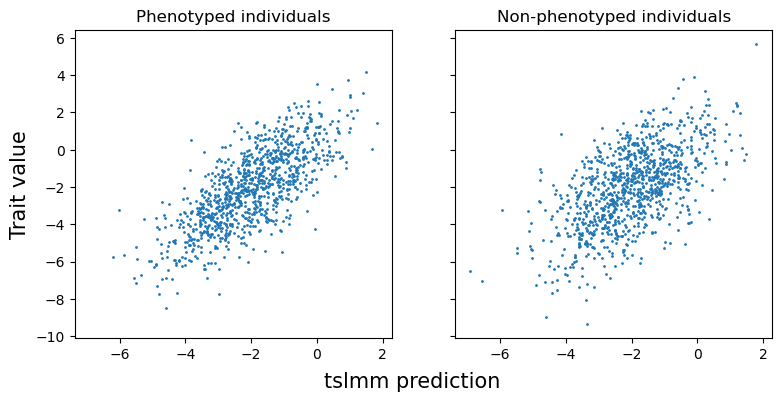

In [6]:
# main scatterplots
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
not_subset = np.setdiff1d(np.arange(ts.num_individuals), subset) # non-phenotyped individuals
ax[0].scatter(blups[subset], traits[subset], s=1)
ax[1].scatter(blups[not_subset], traits[not_subset], s=1)

# annotation
ax[0].set_ylabel('Trait value', fontsize=15)
fig.text(0.5, 0, 'tslmm prediction', fontsize=15, ha='center', va='center')
ax[0].set_title('Phenotyped individuals')
ax[1].set_title('Non-phenotyped individuals')

plt.show()